In [1]:
import numpy as np
import tensorflow as tf
import edward as ed
import pandas as pd
import seaborn as sns

from edward.models import Normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import preprocess_data

In [2]:
file_path = './flavors_of_cacao.csv'

x_train, x_test, y_train, y_test, feature_names = preprocess_data.preprocess_data(file_path, test_pct=0.2)

hparams = tf.contrib.training.HParams(batch_size=32, num_epoch=1, gradient_samples=10, num_samples = 10000)

/home/achang35/PycharmProjects/edward/cacao/preprocess_data.py:55: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  np.logical_or(cacao['species'].str.lower().str.contains(',|(blend)|;'),


In [3]:
class PredictChocolateRatings(object):
    def __init__(self, hparams):
        self.hparams = hparams 
        self.weights_dict = {'w': None, 'b': None}
        
    def fit(self):
        N = x_train.shape[0]  # Number of rows in training data
        D = x_train.shape[1]  # Number of columns in training data

        x_ph = tf.placeholder(tf.float32, [None, D])  # Placeholder variable for x data
        y_ph = tf.placeholder(tf.float32, [None])  # Placeholder variable for y data 

        w = Normal(loc=tf.zeros(D), scale=tf.ones(D))  # Weights prior
        b = Normal(loc=tf.zeros(1.), scale=tf.ones(1.))  # Bias prior
        y = Normal(loc=ed.dot(x_ph, w) + b, scale=1.0)  # Likelihood function

        qw = Normal(loc=tf.get_variable('qw/loc', [D]),
                scale=tf.nn.softplus(tf.get_variable('qw/scale', [D])))  # Variational parameter
        qb = Normal(loc=tf.get_variable('qb/loc', [1]),
                    scale=tf.nn.softplus(tf.get_variable('qb/scale', [1])))  # Variational parameter

        data = preprocess_data.generator([x_train, y_train], hparams.batch_size)  # Passes data in as batches

        n_batch = int(N / hparams.batch_size)  # Scaling parameter

        inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph}) # Reverse variational inference
        inference.initialize(
            n_iter=n_batch * hparams.num_epoch, n_samples=hparams.gradient_samples, scale={y: N / hparams.batch_size}, 
            logdir='log')  # Use TensorBoard to visaulize loss
        tf.global_variables_initializer().run()

        for _ in range(inference.n_iter):
            X_batch, y_batch = next(data)
            info_dict = inference.update({x_ph:X_batch, y_ph: y_batch})
            inference.print_progress(info_dict)
        
        self.weights_dict['w'] = qw.sample(hparams.num_samples).eval()  # Store weight samples in dictionary
        self.weights_dict['b'] = qw.sample(hparams.num_samples).eval()  # Store bias samples in dictionary
           
    def evaluate(self):
        w_ = np.mean(self.weights_dict['w'], 0)  # Get mean of posterior distribution for each weight
        b_ = np.mean(self.weights_dict['b'])

        predicted = np.dot(x_test, w_) + b_

        mse = mean_absolute_error(y_test, predicted)
        absolute_mse = mean_squared_error(y_test, predicted)

        print('The mse is', mse, 'and the absolute mse is', absolute_mse)
    
    def visualize_weights(self):
        
        w_ = np.mean(predict_ratings.weights_dict['w'], 0)
        max_indices = np.argpartition(w_, -5)[-5:]
        min_indices = np.argpartition(w_, 5)[:5]
        max_min_indices = np.concatenate((max_indices, min_indices))
        names = feature_names[max_min_indices]
        
        selected_weights = predict_ratings.weights_dict['w'][:,max_min_indices]
        weights_df = pd.DataFrame(selected_weights)
        weights_df.columns = names
        tidy_df = pd.melt(weights_df, var_name='feature')
        
        g = sns.FacetGrid(tidy_df, col='feature', col_wrap=5)
        g.map(sns.kdeplot, "value", shade = True)

In [4]:
predict_ratings = PredictChocolateRatings(hparams)

In [5]:
predict_ratings.fit()

In [6]:
predict_ratings.evaluate()

The mse is 0.6022731066808429 and the absolute mse is 0.5764352690439095


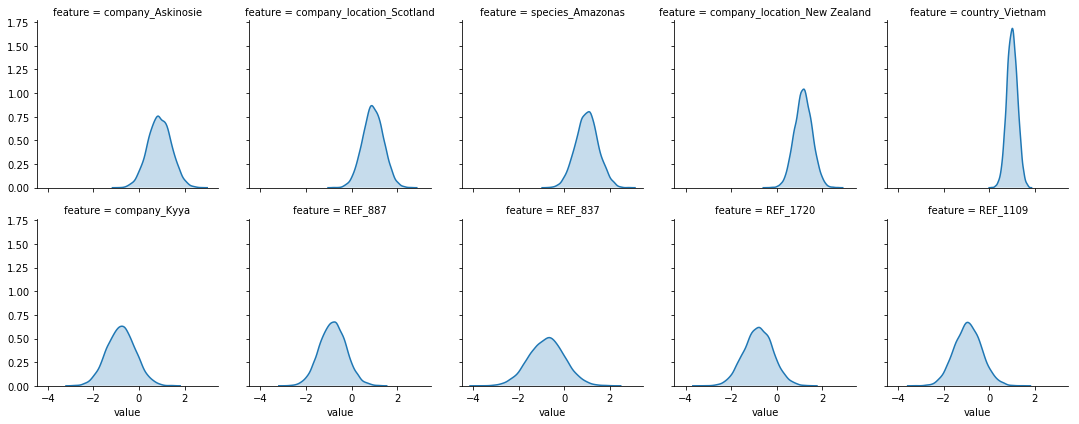

In [7]:
predict_ratings.visualize_weights()